In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, detrend
from scipy import fftpack
from scipy.stats import kurtosis, skew
from sklearn.linear_model import LinearRegression

In [ ]:
data = pd.read_pickle('/home/artem/Documents/2_course/Project ML/WESAD/S2/S2.pkl')

In [3]:
PPG = data['signal']['wrist']['BVP'] # данные с фотоплетизмографа
print(PPG.min(), PPG.max(), PPG.mean())

-873.67 988.08 -0.0004268280144760726


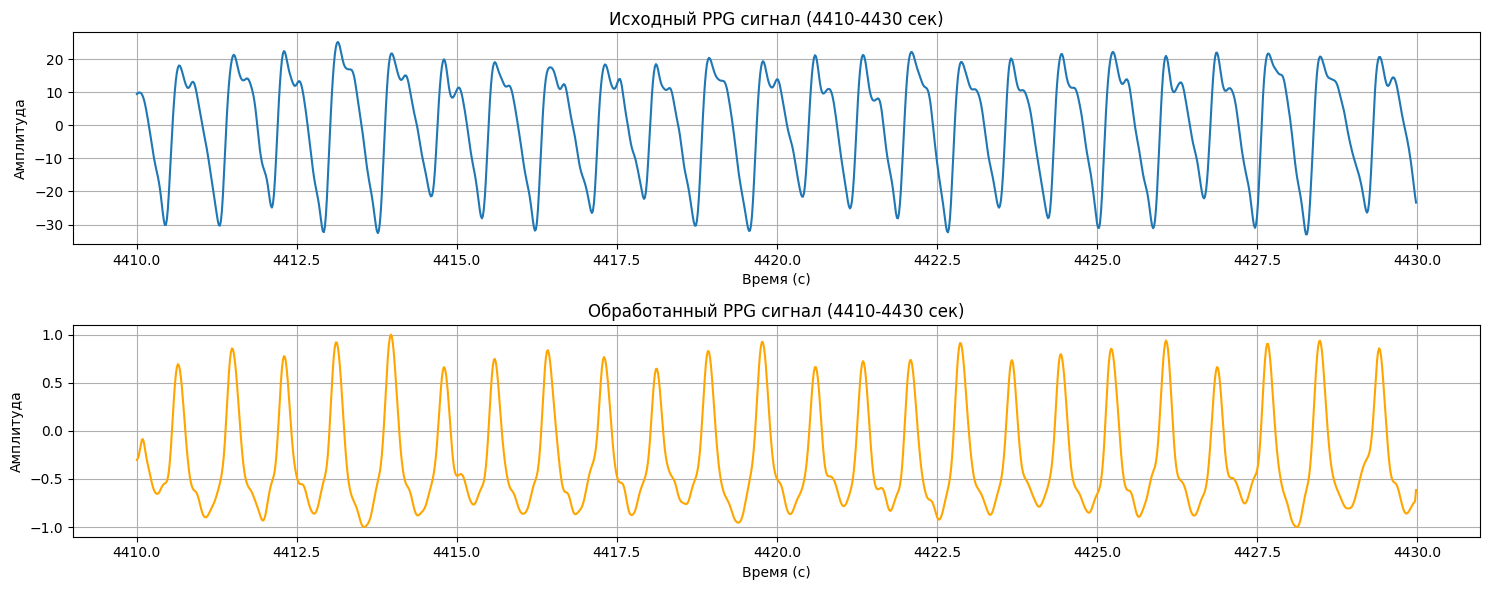

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpassfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return lfilter(b, a, data)

def moving_average(data, window_size=4):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def detrend_signals(signals):
    X = np.arange(len(signals)).reshape(-1, 1)
    return signals - LinearRegression().fit(X, signals).predict(X)


def process_ppg_segment(subject_id, pkl_path, start_second=0, show_plot=True):
    # Загрузка данных
    with open(os.path.join(pkl_path, f'S{subject_id}.pkl'), 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    # Параметры сигнала
    fs = 64  # Частота дискретизации BVP
    bvp_signal = data['signal']['wrist']['BVP'].flatten()
    
    # Рассчет индексов
    start_idx = start_second * fs
    end_idx = start_idx + 20 * fs
    
    # Проверка границ
    if end_idx > len(bvp_signal):
        raise ValueError(f"Данные содержат только {len(bvp_signal)//fs} секунд")
    
    # Выбор сегмента
    raw_segment = bvp_signal[start_idx:end_idx]
    
    # Цепочка обработки
    processed = butter_bandpassfilter(raw_segment, 0.5, 10, fs)
    processed = moving_average(processed)
    processed = detrend_signals(processed)
    processed = MinMaxScaler(feature_range=(-1, 1)).fit_transform(processed.reshape(-1, 1)).flatten()
    
    # Визуализация
    if show_plot:
        time = np.arange(start_second, start_second+20, 1/fs)[:len(raw_segment)]
        
        plt.figure(figsize=(15, 6))
        
        plt.subplot(2, 1, 1)
        plt.plot(time, raw_segment, label='Исходный сигнал')
        plt.title(f'Исходный PPG сигнал ({start_second}-{start_second+20} сек)')
        plt.xlabel('Время (с)')
        plt.ylabel('Амплитуда')
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(time, processed, color='orange', label='После обработки')
        plt.title(f'Обработанный PPG сигнал ({start_second}-{start_second+20} сек)')
        plt.xlabel('Время (с)')
        plt.ylabel('Амплитуда')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return raw_segment, processed

# ================== Пример использования ==================
if __name__ == "__main__":
    # Настройки
    subject_id = 2
    pkl_path = '/home/artem/Documents/2_course/Project ML/WESAD/S2/'
    
    # Интерактивный ввод
    try:
        start = int(input("Введите начальную секунду: "))
        raw, filtered = process_ppg_segment(subject_id, pkl_path, start)
    except Exception as e:
        print(f"Ошибка: {e}")